In [1]:
!cp    /content/drive/MyDrive/skku/lab/sketch_2_svg/samples/ambulance_p.zip /content/
!unzip /content/ambulance_p.zip -d /content/sample_data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/ambulance_processed/5731655589298176.npy  
  inflating: /content/sample_data/ambulance_processed/4971482197262336.npy  
  inflating: /content/sample_data/ambulance_processed/5253631014076416.npy  
  inflating: /content/sample_data/ambulance_processed/5771904566689792.npy  
  inflating: /content/sample_data/ambulance_processed/4672452263149568.npy  
  inflating: /content/sample_data/ambulance_processed/4548048891936768.npy  
  inflating: /content/sample_data/ambulance_processed/5564402482806784.npy  
  inflating: /content/sample_data/ambulance_processed/5874216358379520.npy  
  inflating: /content/sample_data/ambulance_processed/6004819804291072.npy  
  inflating: /content/sample_data/ambulance_processed/5723902321885184.npy  
  inflating: /content/sample_data/ambulance_processed/4704916398407680.npy  
  inflating: /content/sample_data/ambulance_processed/4817903159345152.npy  
  inflating: /content/sam

In [2]:
import tensorflow as tf
import os
import numpy as np

# --- Configuration ---
# 1. Point to your two data folders
BASE_PATH = '/content/sample_data'
PNG_DIR   = os.path.join(BASE_PATH, 'ambulance_png')
NPY_DIR   = os.path.join(BASE_PATH, 'ambulance_processed')

# 2. Set model hyperparameters
BATCH_SIZE  = 32
IMG_SIZE    = 256  # The 256x256 size we created
MAX_SEQ_LEN = 250 # Max points in a drawing. We'll pad to this.
# ---------------------

def get_file_paths(png_dir, npy_dir):
    """
    Finds all matching PNG/NPY pairs and returns two sorted lists.
    """
    png_files = []
    npy_files = []

    # We use the key_id (filename without extension) to match
    key_ids = [f.split('.')[0] for f in os.listdir(png_dir) if f.endswith('.png')]

    for key_id in key_ids:
        png_path = os.path.join(png_dir, f"{key_id}.png")
        npy_path = os.path.join(npy_dir, f"{key_id}.npy")

        # Ensure both files actually exist
        if os.path.exists(png_path) and os.path.exists(npy_path):
            png_files.append(png_path)
            npy_files.append(npy_path)

    print(f"Found {len(png_files)} matching file pairs.")
    return png_files, npy_files

def load_npy_wrapper(npy_path_tensor):
    """
    Wraps np.load to handle the EagerTensor from tf.py_function.
    """
    # 1. Get the raw bytes from the EagerTensor
    npy_path_bytes = npy_path_tensor.numpy()

    # 2. Decode the bytes into a standard Python string
    npy_path_str = npy_path_bytes.decode('utf-8')

    # 3. Now, call np.load with the clean string path
    sequence = np.load(npy_path_str)

    # 4. Cast to float32 to match the output signature
    return sequence.astype(np.float32)

def load_and_preprocess(png_path, npy_path):
    """
    The main parsing function for tf.data.
    Loads and preprocesses one (PNG, NPY) pair.
    """

    # --- 1. Load and process the PNG (Input / X) ---
    # Read the file
    img = tf.io.read_file(png_path)
    # Decode the PNG to a tensor
    img = tf.image.decode_png(img, channels=1) # 1 channel (grayscale)
    # Resize (just in case, but they should be 256)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    # Normalize pixel values from [0, 255] to [-1, 1]
    # This is a common practice that helps models train better.
    img = tf.cast(img, tf.float32) / 127.5 - 1.0

    # --- 2. Load and process the NPY (Target / Y) ---
    # We must use tf.py_function to load with numpy
    # [sequence] = tf.py_function(np.load, [npy_path], [tf.float32])
    [sequence] = tf.py_function(load_npy_wrapper, [npy_path], [tf.float32])

    # --- 3. Truncate or Pad the sequence ---

    # First, TRUNCATE any sequence that is TOO LONG
    sequence = sequence[:MAX_SEQ_LEN, :]

    # Now, PAD any sequence that is TOO SHORT
    seq_len = tf.shape(sequence)[0]
    padding = [[0, MAX_SEQ_LEN - seq_len], [0, 0]]
    sequence = tf.pad(sequence, padding, 'CONSTANT')

    # Set the final shape, which is now known
    sequence.set_shape([MAX_SEQ_LEN, 5])

    # The model's target will be the sequence "shifted by one"
    # Target (Y): The sequence to be predicted
    # Input (X_decoder): The same sequence, one step behind

    # Decoder Input: (e.g., [START, p1, p2, p3, ...])
    decoder_input = sequence
    # Target Output: (e.g., [p1, p2, p3, END, ...])
    decoder_target = tf.roll(sequence, shift=-1, axis=0)

    # Our model needs two inputs (image, decoder_input) and one output (target)
    return (img, decoder_input), decoder_target

# --- Main execution ---
def create_dataset(png_dir, npy_dir, batch_size):
    """Builds the final tf.data.Dataset object."""

    # 1. Get the lists of file paths
    png_files, npy_files = get_file_paths(png_dir, npy_dir)
    if not png_files:
        print("No files found. Exiting.")
        return None

    # 2. Create a dataset of the file paths
    path_ds = tf.data.Dataset.from_tensor_slices((png_files, npy_files))

    # 3. Use .map() to load and preprocess the data
    #    num_parallel_calls=tf.data.AUTOTUNE lets TF load in parallel
    dataset = path_ds.map(load_and_preprocess,
                          num_parallel_calls=tf.data.AUTOTUNE)

    # 4. Shuffle, batch, and prefetch for performance
    dataset = (
        dataset
        .shuffle(buffer_size=1024)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    return dataset

# --- Run it ---
if __name__ == "__main__":
    train_dataset = create_dataset(PNG_DIR, NPY_DIR, BATCH_SIZE)

    if train_dataset:
        print("\n--- Dataset Created Successfully ---")
        # Let's inspect one batch to confirm shapes
        for (img_batch, seq_in_batch), seq_out_batch in train_dataset.take(1):
            print(f"Image Batch Shape (X_img):   {img_batch.shape}")
            print(f"Sequence Input Shape (X_dec): {seq_in_batch.shape}")
            print(f"Sequence Target Shape (Y):   {seq_out_batch.shape}")

        print("\nData pipeline is ready.")

Found 10000 matching file pairs.

--- Dataset Created Successfully ---
Image Batch Shape (X_img):   (32, 256, 256, 1)
Sequence Input Shape (X_dec): (32, 250, 5)
Sequence Target Shape (Y):   (32, 250, 5)

Data pipeline is ready.


Loading trained model...
Building inference decoder from trained weights...
Inference model built.
Loaded test image: /content/sample_data/ambulance_png/5388983636852736.png
Generating sequence (point by point)...
Model predicted <END> token at step 0. Stopping.
Sequence generation finished.

--- Success! ---
Predicted drawing saved to: /content/drive/MyDrive/skku/lab/sketch_2_svg/output/predicted_5388983636852736.svg
Original PNG:


Generated SVG:


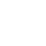

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display, HTML, SVG # <-- Make sure SVG is imported

# --- 1. Configuration ---
# (Must match your training script)
IMG_SIZE      = 256
MAX_SEQ_LEN   = 250
LATENT_DIM    = 256
RNN_UNITS     = 512
NORMALIZE_DIM = 255.0 # For scaling SVG output

# Path to your saved model
MODEL_PATH = '/content/drive/MyDrive/skku/lab/sketch_2_svg/weights/test.keras'
# Path to your PNG folder
PNG_DIR    = '/content/sample_data/ambulance_png'
# Output directory for the generated SVG
OUTPUT_DIR = "/content/drive/MyDrive/skku/lab/sketch_2_svg/output"
# ---------------------

# --- 2. Helper function to load and process a single PNG ---
def load_test_image(png_path):
    img = tf.io.read_file(png_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 127.5 - 1.0
    # Add a batch dimension (1, 256, 256, 1)
    return tf.expand_dims(img, axis=0)

# --- 3. Helper function to turn the predicted sequence into an SVG ---
def sequence_to_svg(sequence, img_size=NORMALIZE_DIM):
    """
    Converts a (dx, dy, p1, p2, p3) sequence back into an SVG file string.
    """
    # Find the bounding box
    min_x, min_y = 0, 0
    max_x, max_y = 0, 0

    current_x, current_y = 0, 0
    # Calculate bounding box
    for point in sequence:
        dx, dy = point[0], point[1]
        current_x += dx
        current_y += dy
        min_x = min(min_x, current_x)
        min_y = min(min_y, current_y)
        max_x = max(max_x, current_x)
        max_y = max(max_y, current_y)

    # Calculate the square viewBox
    width  = max_x - min_x
    height = max_y - min_y
    side   = max(width, height) + 20 # Add 20 padding

    # Handle the case of a single point (or no points)
    if side <= 20: # Check if side is too small
        side = NORMALIZE_DIM + 20 # Use a default size
        min_x = -10 # Center the default viewBox
        min_y = -10

    viewBox = f"{min_x - 10} {min_y - 10} {side} {side}"

    # Start the SVG
    svg_lines = [
        f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="{viewBox}" width="500">',
        '  <rect width="100%" height="100%" fill="white"></rect>',
        '  <path d="' # Start the first path
    ]

    # Second pass to build the path string
    current_x, current_y = 0, 0
    is_first_point_in_stroke = True

    for point in sequence:
        dx, dy = point[0], point[1]
        p_end_stroke = point[3] > 0.5
        p_end_drawing = point[4] > 0.5

        # Update position
        current_x += dx
        current_y += dy

        if is_first_point_in_stroke:
            svg_lines[-1] += f'M {current_x:.2f} {current_y:.2f}'
            is_first_point_in_stroke = False
        else:
            svg_lines[-1] += f' L {current_x:.2f} {current_y:.2f}'

        if p_end_drawing:
            break
        elif p_end_stroke:
            if not is_first_point_in_stroke: # Only close if there were points
                svg_lines[-1] += '" stroke="black" stroke-width="1" fill="none" />'
                # Start a new <path> element for the next stroke
                svg_lines.append('  <path d="')
            is_first_point_in_stroke = True

    # Close any open paths or remove empty path elements
    if svg_lines[-1].strip() == '  <path d="': # Handle empty path
        svg_lines.pop()
    elif not svg_lines[-1].endswith('/>'):
        svg_lines[-1] += '" stroke="black" stroke-width="1" fill="none" />'

    svg_lines.append('</svg>')
    return '\n'.join(svg_lines)

# --- 4. Custom Loss Function (REQUIRED FOR LOADING) ---
# This must be defined to load the model.
def custom_loss(y_true, y_pred):
    # Split the 5-element vector
    # True values
    true_dx_dy = y_true[:, :, 0:2]  # (batch, seq_len, 2)
    true_p = y_true[:, :, 2:5]      # (batch, seq_len, 3)

    # Predicted values
    pred_dx_dy = y_pred[:, :, 0:2]
    pred_p = y_pred[:, :, 2:5]

    # Loss 1: Mean Squared Error for (dx, dy)
    squared_error_dx_dy = tf.square(true_dx_dy - pred_dx_dy)
    loss_dx_dy = tf.reduce_mean(squared_error_dx_dy, axis=-1)

    # Loss 2: Cross-Entropy for (p1, p2, p3)
    cce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    loss_p = cce_loss(true_p, pred_p)

    # Mask to ignore padded steps
    mask = tf.cast(tf.reduce_any(y_true != 0.0, axis=-1), tf.float32)

    # Apply the mask to both losses
    loss_dx_dy = loss_dx_dy * mask
    loss_p = loss_p * mask

    # Combine losses
    total_loss = loss_dx_dy + loss_p
    return tf.reduce_mean(total_loss)

# --- 5. Main Inference Function (REBUILT) ---
def generate_drawing(model_path, test_png_path):
    print("Loading trained model...")

    # Load the full model to get the weights
    full_model = keras.models.load_model(
        model_path,
        custom_objects={'custom_loss': custom_loss}
    )

    # Extract the encoder
    encoder = full_model.get_layer('encoder')

    # Extract the trained decoder to get its weights
    trained_decoder = full_model.get_layer('decoder')

    # --- Build a new, stateful inference decoder ---
    print("Building inference decoder from trained weights...")

    # 1. Get weights from the trained decoder
    state_projector_weights = trained_decoder.get_layer('dense_1').get_weights()
    lstm_weights = trained_decoder.get_layer('decoder_lstm').get_weights()
    output_layer_weights = trained_decoder.get_layer('decoder_output').get_weights()

    # 2. Define new layers for inference
    inf_encoder_state_in = layers.Input(shape=(LATENT_DIM,), name="inf_encoder_state_in")
    inf_point_input = layers.Input(shape=(1, 5), name="inf_point_input")
    inf_state_h_in = layers.Input(shape=(RNN_UNITS,), name="inf_state_h_in")
    inf_state_c_in = layers.Input(shape=(RNN_UNITS,), name="inf_state_c_in")

    # 3. Re-create the layer graph
    state_projector_layer = layers.Dense(RNN_UNITS, name="inf_state_projector")
    initial_h = state_projector_layer(inf_encoder_state_in)
    initial_c = state_projector_layer(inf_encoder_state_in)
    initial_state_model = keras.Model(inf_encoder_state_in, [initial_h, initial_c])

    lstm_layer = layers.LSTM(RNN_UNITS, return_sequences=True, return_state=True, name="inf_lstm")
    lstm_output, state_h_out, state_c_out = lstm_layer(
        inf_point_input,
        initial_state=[inf_state_h_in, inf_state_c_in]
    )

    output_layer = layers.Dense(5, activation='linear', name="inf_output_layer")
    output_point = output_layer(lstm_output)

    decoder_step_model = keras.Model(
        [inf_point_input, inf_state_h_in, inf_state_c_in],
        [output_point, state_h_out, state_c_out]
    )

    # 4. Set the weights on the new layers
    state_projector_layer.set_weights(state_projector_weights)
    lstm_layer.set_weights(lstm_weights)
    output_layer.set_weights(output_layer_weights)

    print("Inference model built.")

    # --- Now we can run inference ---

    # Load and preprocess the test image
    test_image = load_test_image(test_png_path)
    print(f"Loaded test image: {test_png_path}")

    # --- Run the Encoder ---
    encoder_output = encoder(test_image)

    # --- Run the Decoder Autoregressively ---
    hidden_state, cell_state = initial_state_model(encoder_output)
    current_point = tf.zeros((1, 1, 5))
    generated_sequence = []

    print("Generating sequence (point by point)...")
    for t in range(MAX_SEQ_LEN):
        predicted_point, hidden_state, cell_state = decoder_step_model(
            [current_point, hidden_state, cell_state]
        )

        # Store the prediction
        point_squeezed = tf.squeeze(predicted_point, axis=[0, 1])
        generated_sequence.append(point_squeezed.numpy())

        # Set the *next* input point
        current_point = predicted_point

        # Check for the "End of Drawing" token (p3)
        end_drawing_prob = tf.sigmoid(predicted_point[0, 0, 4]).numpy()
        if end_drawing_prob > 0.5:
            print(f"Model predicted <END> token at step {t}. Stopping.")
            break

    print("Sequence generation finished.")
    return np.array(generated_sequence)

# --- 6. Run Everything ---
# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Find a test image
if not os.path.exists(PNG_DIR) or not os.listdir(PNG_DIR):
    print(f"Error: PNG directory not found or is empty: {PNG_DIR}")
else:
    test_img_name = os.listdir(PNG_DIR)[0] # Get the first image
    test_img_path = os.path.join(PNG_DIR, test_img_name)

    # Generate the sequence
    predicted_sequence = generate_drawing(MODEL_PATH, test_img_path)

    # Convert sequence to SVG
    svg_string = sequence_to_svg(predicted_sequence)

    # Save the SVG to your new path
    base_name, _ = os.path.splitext(test_img_name)
    output_svg_path = os.path.join(OUTPUT_DIR, f"predicted_{base_name}.svg")
    with open(output_svg_path, 'w') as f:
        f.write(svg_string)

    print(f"\n--- Success! ---")
    print(f"Predicted drawing saved to: {output_svg_path}")

    # Display the original and the new SVG (in Colab)
    print("Original PNG:")
    display(HTML(f'<img src="{test_img_path}" width="200">'))

    print("Generated SVG:")
    # Display the SVG string directly. This is the best way in Colab.
    display(SVG(data=svg_string))

Found 10000 matching file pairs.
Total batches: 312
Training steps per epoch: 249
Validation steps per epoch: 63

--- Starting Model Training ---
Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 55s 200ms/step - loss: 264.9273 - val_loss: 230.1595
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 48s 188ms/step - loss: 217.8791 - val_loss: 235.1155
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 50s 192ms/step - loss: 200.4292 - val_loss: 217.8628
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 196ms/step - loss: 180.0693 - val_loss: 196.4133
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 48s 188ms/step - loss: 167.2906 - val_loss: 197.4886
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 193ms/step - loss: 160.5628 - val_loss: 194.0646
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 81s 188ms/step - loss: 153.7080 - val_loss: 204.9306
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 192ms/step - loss: 152.0859 - val_loss: 190.4715
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 49s 193ms/step - loss: 150.4957 - val_loss: 185.6601
Epoch 10/20
249/2

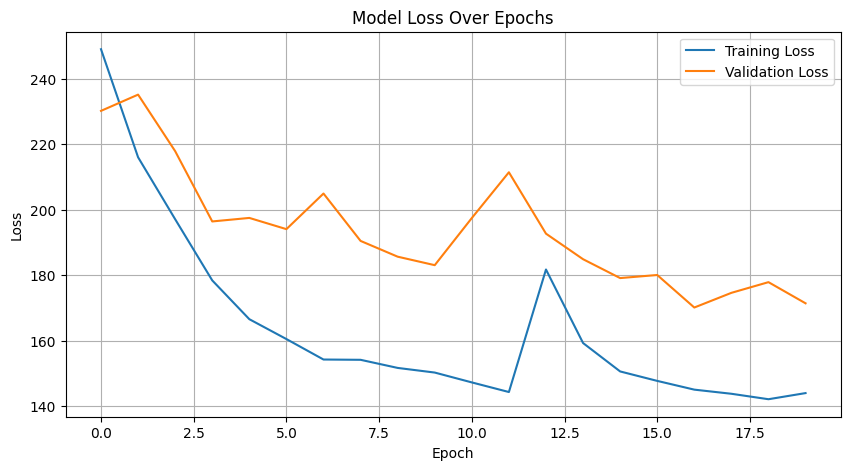

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

# --- 1. Re-define key variables (if in a new cell) ---
# (Make sure the variables from your data pipeline script are available)
# BATCH_SIZE = 32
# PNG_DIR = '...'
# NPY_DIR = '...'
# model = ... (the model you just built)
# create_dataset = ... (the function from your previous script)
EPOCHS = 20 # You can start with 20 and increase if needed

# --- 2. Create the full dataset ---
# This re-creates the full, batched, and shuffled dataset
full_batched_dataset = create_dataset(PNG_DIR, NPY_DIR, BATCH_SIZE)

# --- 3. Split the dataset into Train and Validation ---
# We know from your logs we have 10,000 samples
DATASET_SIZE = 10000

# Calculate the number of batches for an 80/20 split
total_batches = DATASET_SIZE // BATCH_SIZE
train_steps = int(total_batches * 0.8)
val_steps = total_batches - train_steps

# .take() gets the first 80% of batches
train_data = full_batched_dataset.take(train_steps)
# .skip() skips the first 80%, and .take() gets the remaining 20%
val_data = full_batched_dataset.skip(train_steps).take(val_steps)

print(f"Total batches: {total_batches}")
print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")


# --- 4. Create a Model Checkpoint Callback ---
# This saves the best model during training
checkpoint_dir = "./model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "best_model.keras")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Save the full model
    monitor='val_loss',       # Monitor the validation loss
    mode='min',               # We want to minimize the loss
    save_best_only=True)      # Only save the best one


# --- 5. Train the Model! ---
print("\n--- Starting Model Training ---")

history = model.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=val_data,
    validation_steps=val_steps,
    callbacks=[model_checkpoint_callback]  # Pass in our callback
)

print("--- Training Complete ---")
print(f"Best model saved to: {checkpoint_path}")


# --- 6. Plot the Training Results ---
print("\nPlotting training and validation loss...")
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# --- 1. Configuration ---
# (Must match your training script)
IMG_SIZE      = 256
MAX_SEQ_LEN   = 250
LATENT_DIM    = 256
RNN_UNITS     = 512
NORMALIZE_DIM = 255.0 # For scaling SVG output

# Path to your saved model
MODEL_PATH = '/content/drive/MyDrive/skku/lab/sketch_2_svg/weights/test.keras'
# Path to your PNG folder
PNG_DIR = '/content/sample_data/ambulance_png'
# ---------------------

# --- 2. Helper function to load and process a single PNG ---
def load_test_image(png_path):
    img = tf.io.read_file(png_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 127.5 - 1.0
    # Add a batch dimension (1, 256, 256, 1)
    return tf.expand_dims(img, axis=0)

# --- 3. Helper function to turn the predicted sequence into an SVG ---
def sequence_to_svg(sequence, img_size=NORMALIZE_DIM):
    """
    Converts a (dx, dy, p1, p2, p3) sequence back into an SVG file string.
    (This is the corrected version)
    """
    # Find the bounding box
    min_x, min_y = 0, 0
    max_x, max_y = 0, 0

    current_x, current_y = 0, 0
    # Calculate bounding box
    for point in sequence:
        dx, dy = point[0], point[1]
        current_x += dx
        current_y += dy
        min_x = min(min_x, current_x)
        min_y = min(min_y, current_y)
        max_x = max(max_x, current_x)
        max_y = max(max_y, current_y)

    # Calculate the square viewBox
    width = max_x - min_x
    height = max_y - min_y
    side = max(width, height) + 20 # Add 20 padding

    # Handle the case of a single point (or no points)
    if side <= 20: # Check if side is too small (might happen with very few points)
        side = NORMALIZE_DIM + 20 # Use a default size
        min_x = -10 # Center the default viewBox
        min_y = -10

    viewBox = f"{min_x - 10} {min_y - 10} {side} {side}"

    # Start the SVG
    svg_lines = [
        f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="{viewBox}" width="500">',
        '  <rect width="100%" height="100%" fill="white"></rect>',
        '  <path d="' # Start the first path
    ]

    # Second pass to build the path string
    current_x, current_y = 0, 0
    is_first_point_in_stroke = True

    for point in sequence:
        dx, dy = point[0], point[1]
        p_end_stroke = point[3] > 0.5
        p_end_drawing = point[4] > 0.5

        # Update position
        current_x += dx
        current_y += dy

        if is_first_point_in_stroke:
            svg_lines[-1] += f'M {current_x:.2f} {current_y:.2f}'
            is_first_point_in_stroke = False
        else:
            svg_lines[-1] += f' L {current_x:.2f} {current_y:.2f}'

        if p_end_drawing:
            break
        elif p_end_stroke:
            if not is_first_point_in_stroke: # Only close if there were points in this stroke
                svg_lines[-1] += '" stroke="black" stroke-width="1" fill="none" />'
                # Start a new <path> element for the next stroke
                svg_lines.append('  <path d="')
            is_first_point_in_stroke = True

    # Close any open paths or remove empty path elements
    if svg_lines[-1].strip() == '<path d="': # Handle empty path
        svg_lines.pop()
    elif not svg_lines[-1].endswith('/>'):
        svg_lines[-1] += '" stroke="black" stroke-width="1" fill="none" />'

    svg_lines.append('</svg>')
    return '\n'.join(svg_lines)

# --- 4. Main Inference Function (REBUILT) ---
def generate_drawing(model_path, test_png_path):
    print("Loading trained model...")

    # Load the full model to get the weights
    full_model = keras.models.load_model(
        model_path,
        custom_objects={'custom_loss': custom_loss}
    )

    # Extract the encoder
    encoder = full_model.get_layer('encoder')

    # Extract the trained decoder to get its weights
    trained_decoder = full_model.get_layer('decoder')

    # --- Build a new, stateful inference decoder ---
    print("Building inference decoder from trained weights...")

    # 1. Get weights from the trained decoder
    state_projector_weights = trained_decoder.get_layer('dense_1').get_weights()
    lstm_weights = trained_decoder.get_layer('decoder_lstm').get_weights()
    output_layer_weights = trained_decoder.get_layer('decoder_output').get_weights()

    # 2. Define new layers for inference
    # Input for the encoder's "thought vector"
    inf_encoder_state_in = layers.Input(shape=(LATENT_DIM,), name="inf_encoder_state_in")

    # Input for the single point (t)
    inf_point_input = layers.Input(shape=(1, 5), name="inf_point_input")

    # Input for the states (h, c)
    inf_state_h_in = layers.Input(shape=(RNN_UNITS,), name="inf_state_h_in")
    inf_state_c_in = layers.Input(shape=(RNN_UNITS,), name="inf_state_c_in")

    # 3. Re-create the layer graph

    # State projector
    state_projector_layer = layers.Dense(RNN_UNITS, name="inf_state_projector")
    initial_h = state_projector_layer(inf_encoder_state_in)
    initial_c = state_projector_layer(inf_encoder_state_in)

    # This model just gets the initial state from the encoder output
    initial_state_model = keras.Model(inf_encoder_state_in, [initial_h, initial_c])

    # LSTM
    # This one MUST have return_state=True
    lstm_layer = layers.LSTM(RNN_UNITS, return_sequences=True, return_state=True, name="inf_lstm")
    lstm_output, state_h_out, state_c_out = lstm_layer(
        inf_point_input,
        initial_state=[inf_state_h_in, inf_state_c_in]
    )

    # Output layer
    output_layer = layers.Dense(5, activation='linear', name="inf_output_layer")
    output_point = output_layer(lstm_output)

    # Create the final one-step decoder model
    decoder_step_model = keras.Model(
        [inf_point_input, inf_state_h_in, inf_state_c_in],
        [output_point, state_h_out, state_c_out]
    )

    # 4. Set the weights on the new layers
    state_projector_layer.set_weights(state_projector_weights)
    lstm_layer.set_weights(lstm_weights)
    output_layer.set_weights(output_layer_weights)

    print("Inference model built.")

    # --- Now we can run inference ---

    # Find a test image
    # Check if PNG_DIR exists and contains files
    if not os.path.exists(PNG_DIR) or not os.listdir(PNG_DIR):
        print(f"Error: PNG directory not found or is empty: {PNG_DIR}")
        test_img_path = None # Set to None if no images found
    else:
        test_img_name = os.listdir(PNG_DIR)[0] # Get the first image
        test_img_path = os.path.join(PNG_DIR, test_img_name)


    if test_img_path:
        # Load and preprocess the test image
        test_image = load_test_image(test_img_path)
        print(f"Loaded test image: {test_png_path}")

        # --- Run the Encoder ---
        # Get the "thought vector" from the image
        encoder_output = encoder(test_image)

        # --- Run the Decoder Autoregressively ---

        # 1. Get the initial h and c states from the encoder output
        hidden_state, cell_state = initial_state_model(encoder_output)

        # 2. Start with a "START" token: a single (1, 1, 5) tensor of zeros
        current_point = tf.zeros((1, 1, 5))

        # 3. We'll store all predicted points here
        generated_sequence = []

        print("Generating sequence (point by point)...")
        for t in range(MAX_SEQ_LEN):

            # Run the one-step decoder
            predicted_point, hidden_state, cell_state = decoder_step_model(
                [current_point, hidden_state, cell_state]
            )

            # --- Prepare for the next loop ---
            # 1. Store the prediction (remove batch dims)
            point_squeezed = tf.squeeze(predicted_point, axis=[0, 1])
            generated_sequence.append(point_squeezed.numpy())

            # 2. Set the *next* input point
            current_point = predicted_point

            # 3. Check for the "End of Drawing" token (p3)
            # Use sigmoid to get probability from logit
            end_drawing_prob = tf.sigmoid(predicted_point[0, 0, 4]).numpy()
            if end_drawing_prob > 0.5: # Check probability > 0.5
                print(f"Model predicted <END> token with probability {end_drawing_prob:.2f} at step {t}. Stopping.")
                break

        print("Sequence generation finished.")
        # Convert the list of points to a NumPy array
        predicted_sequence = np.array(generated_sequence)

        # Convert sequence to SVG
        svg_string = sequence_to_svg(predicted_sequence)

        # Define your new output directory
        OUTPUT_DIR = "/content/drive/MyDrive/skku/lab/sketch_2_svg/output"
        # Create it if it doesn't exist
        os.makedirs(OUTPUT_DIR, exist_ok=True)

        # Save the SVG to your new path
        # Ensure the output file name has a .svg extension
        base_name, _ = os.path.splitext(test_img_name)
        output_svg_path = os.path.join(OUTPUT_DIR, f"predicted_{base_name}.svg")
        with open(output_svg_path, 'w') as f:
            f.write(svg_string)

        print(f"\n--- Success! ---")
        print(f"Predicted drawing saved to: {output_svg_path}")

        # Display the original and the new SVG (in Colab)
        print("Original PNG:")
        display(HTML(f'<img src="{test_img_path}" width="200">'))

        print("Generated SVG (as HTML):")
        # Display the SVG content directly as HTML
        display(HTML(svg_string))

        print("Generated SVG (as image):")
        # Add a cache-buster to the query string to force Colab to reload the image
        display(HTML(f'<img src="{output_svg_path}?t={np.random.rand()}" width="200">'))
    else:
        print("No test image found to process.")